In [1]:
# Imports + Paths + DuckDB connect + Load assignment parquet

import duckdb
import numpy as np
import pandas as pd
from pathlib import Path

DATA_DIR = Path("../data")
SALT = "pdp_ui_v1"  # <-- 改这里：与 Phase 5/6 一致
ASSIGN_PATH = DATA_DIR / f"assignment_{SALT}.parquet"
SEG_PATH = DATA_DIR / "user_segment.csv"

assert ASSIGN_PATH.exists(), f"Missing: {ASSIGN_PATH}"

con = duckdb.connect(database=":memory:")

con.execute(f"""
CREATE OR REPLACE VIEW assignment AS
SELECT *
FROM read_parquet('{ASSIGN_PATH.as_posix()}')
""")

con.execute("SELECT COUNT(*) AS n FROM assignment").df()


,n
0,5316128


In [2]:
# Cell B｜Load segments + Build base view
# Load user_segment if exists; keep pipeline stable if missing
if SEG_PATH.exists():
    con.execute(f"""
    CREATE OR REPLACE VIEW user_segment AS
    SELECT
      CAST("user_id" AS BIGINT) AS user_id,
      CAST("user_type" AS VARCHAR) AS user_type,
      "first_seen_time" AS first_seen_time
    FROM read_csv_auto('{SEG_PATH.as_posix()}', HEADER=TRUE)
    """)
    print("Loaded segments:", SEG_PATH)
else:
    con.execute("""
    CREATE OR REPLACE VIEW user_segment AS
    SELECT CAST(NULL AS BIGINT) AS user_id,
           CAST(NULL AS VARCHAR) AS user_type,
           CAST(NULL AS VARCHAR) AS first_seen_time
    WHERE FALSE
    """)
    print("⚠️ Missing user_segment.csv. Will use Unknown segment.")

# PDP base:
# exposed = view
# primary_outcome = cart
# keep purchase column for downstream mapping (cart -> purchase)
con.execute("""
CREATE OR REPLACE VIEW base AS
SELECT
  a.user_id,
  CAST(a.variant AS INTEGER) AS variant,
  CAST(a.view AS BOOLEAN) AS exposed,
  CAST(a.cart AS BOOLEAN) AS cart,
  CAST(a.purchase AS BOOLEAN) AS purchase,
  COALESCE(s.user_type, 'Unknown') AS segment_raw
FROM assignment a
LEFT JOIN user_segment s
ON a.user_id = s.user_id
""")

# Sanity check
con.execute("""
SELECT
  COUNT(*) AS n,
  AVG(CASE WHEN exposed THEN 1 ELSE 0 END) AS exposed_rate,
  AVG(CASE WHEN cart THEN 1 ELSE 0 END) AS cart_rate,
  AVG(CASE WHEN purchase THEN 1 ELSE 0 END) AS purchase_rate,
  AVG(CASE WHEN segment_raw <> 'Unknown' THEN 1 ELSE 0 END) AS segment_coverage
FROM base
""").df()


Loaded segments: ..\data\user_segment.csv


,n,exposed_rate,cart_rate,purchase_rate,segment_coverage
0,5316128,1.0,0.198001,0.101412,1.0


In [3]:
# Phase 7 Inputs

WINDOW_DAYS = 30
DAYS_PER_YEAR = 365
ANNUALIZE_FACTOR = DAYS_PER_YEAR / WINDOW_DAYS

AOV = 80.0

COST_BEST = 20_000
COST_BASE = 80_000
COST_WORST = 200_000

ROLLOUT_SCENARIOS = ["all_users", "new_only"]

(WINDOW_DAYS, AOV, ANNUALIZE_FACTOR, ROLLOUT_SCENARIOS)


(30, 80.0, 12.166666666666666, ['all_users', 'new_only'])

In [4]:
# Exposure-aware uplift simulation（只对 treated ∩ exposed ∩ not purchased 抽样翻转）

UPLIFT_REL = 0.05  # 5% relative lift on cart among exposed
SEED = 42
rng = np.random.default_rng(SEED)

# Baseline cart rate among exposed control (variant=0 & exposed)
p0 = con.execute("""
SELECT AVG(CASE WHEN cart THEN 1 ELSE 0 END) AS p0
FROM base
WHERE variant = 0 AND exposed = TRUE
""").df()["p0"].iloc[0]

p1 = min(1.0, p0 * (1 + UPLIFT_REL))
delta = max(0.0, p1 - p0)

print("p0_cart_exposed_control =", p0)
print("p1_target =", p1)
print("delta(one-sided) =", delta)

# Candidates: treated & exposed & NOT already cart
candidates = con.execute("""
SELECT user_id
FROM base
WHERE variant = 1 AND exposed = TRUE AND cart = FALSE
""").df()

n_cand = len(candidates)
flip_mask = rng.random(n_cand) < delta

flips = candidates.loc[flip_mask, ["user_id"]].copy()
flips["flip"] = 1

print("Candidates:", n_cand)
print("Flips:", len(flips), f"({len(flips)/max(n_cand,1):.2%} of candidates)")

con.register("flips_df", flips)

# cart_sim = cart OR flip
con.execute("""
CREATE OR REPLACE VIEW sim AS
SELECT
  b.user_id,
  b.variant,
  b.exposed,
  b.cart,
  b.purchase,
  CASE WHEN f.flip = 1 THEN TRUE ELSE b.cart END AS cart_sim,
  b.segment_raw
FROM base b
LEFT JOIN flips_df f
ON b.user_id = f.user_id
""")

con.execute("""
SELECT
  COUNT(*) AS n,
  AVG(CASE WHEN cart_sim THEN 1 ELSE 0 END) AS sim_cart_rate
FROM sim
""").df()


p0_cart_exposed_control = 0.19822363487716696
p1_target = 0.20813481662102531
delta(one-sided) = 0.009911181743858355
Candidates: 2131497
Flips: 21011 (0.99% of candidates)


,n,sim_cart_rate
0,5316128,0.201953


In [5]:
# Compute causal metrics (ITT / CATE / Placebo) + segment uplift（Phase 7 的输入）

from statsmodels.stats.proportion import proportions_ztest
import numpy as np

def two_prop_ci(p1, p0, n1, n0, alpha=0.05):
    se = np.sqrt(p1*(1-p1)/n1 + p0*(1-p0)/n0)
    z = 1.959963984540054
    diff = p1 - p0
    return diff, diff - z*se, diff + z*se

# --- ITT (all users) on cart_sim ---
itt = con.execute("""
SELECT
  variant,
  COUNT(*) AS n_users,
  SUM(CASE WHEN cart_sim THEN 1 ELSE 0 END) AS add_to_carts
FROM sim
GROUP BY variant
ORDER BY variant
""").df()

p0 = itt.loc[itt["variant"]==0, "add_to_carts"].iloc[0] / itt.loc[itt["variant"]==0, "n_users"].iloc[0]
p1 = itt.loc[itt["variant"]==1, "add_to_carts"].iloc[0] / itt.loc[itt["variant"]==1, "n_users"].iloc[0]
n0 = itt.loc[itt["variant"]==0, "n_users"].iloc[0]
n1 = itt.loc[itt["variant"]==1, "n_users"].iloc[0]

diff, ci_low, ci_high = two_prop_ci(p1, p0, n1, n0)
z, pval = proportions_ztest(
    count=[itt.loc[itt["variant"]==1, "add_to_carts"].iloc[0],
           itt.loc[itt["variant"]==0, "add_to_carts"].iloc[0]],
    nobs=[n1, n0]
)

metrics_itt = pd.DataFrame([{
    "metric": "ITT (Global, Add-to-Cart)",
    "p_treat": p1, "p_control": p0,
    "diff": diff, "ci_low": ci_low, "ci_high": ci_high,
    "z": z, "p_value": pval
}])

display(itt)
display(metrics_itt)

# --- CATE (exposed only) on cart_sim ---
cate = con.execute("""
SELECT
  variant,
  COUNT(*) AS n_exposed,
  SUM(CASE WHEN cart_sim THEN 1 ELSE 0 END) AS add_to_carts_exposed
FROM sim
WHERE exposed = TRUE
GROUP BY variant
ORDER BY variant
""").df()

p0 = cate.loc[cate["variant"]==0, "add_to_carts_exposed"].iloc[0] / cate.loc[cate["variant"]==0, "n_exposed"].iloc[0]
p1 = cate.loc[cate["variant"]==1, "add_to_carts_exposed"].iloc[0] / cate.loc[cate["variant"]==1, "n_exposed"].iloc[0]
n0 = cate.loc[cate["variant"]==0, "n_exposed"].iloc[0]
n1 = cate.loc[cate["variant"]==1, "n_exposed"].iloc[0]

diff, ci_low, ci_high = two_prop_ci(p1, p0, n1, n0)
z, pval = proportions_ztest(
    count=[cate.loc[cate["variant"]==1, "add_to_carts_exposed"].iloc[0],
           cate.loc[cate["variant"]==0, "add_to_carts_exposed"].iloc[0]],
    nobs=[n1, n0]
)

metrics_cate = pd.DataFrame([{
    "metric": "CATE (Local, Exposed Only, Add-to-Cart)",
    "p_treat": p1, "p_control": p0,
    "diff": diff, "ci_low": ci_low, "ci_high": ci_high,
    "z": z, "p_value": pval
}])

display(cate)
display(metrics_cate)

# --- Placebo (non-exposed only) on cart_sim ---
placebo = con.execute("""
SELECT
  variant,
  COUNT(*) AS n_non_exposed,
  SUM(CASE WHEN cart_sim THEN 1 ELSE 0 END) AS add_to_carts_non_exposed
FROM sim
WHERE exposed = FALSE
GROUP BY variant
ORDER BY variant
""").df()

display(placebo)



,variant,n_users,add_to_carts
0,0,2659138,527104.0
1,1,2656990,546504.0


,metric,p_treat,p_control,diff,ci_low,ci_high,z,p_value
0,"ITT (Global, Add-to-Cart)",0.205685,0.198224,0.007462,0.006779,0.008144,21.427364,7.426715e-102


,variant,n_exposed,add_to_carts_exposed
0,0,2659138,527104.0
1,1,2656990,546504.0


,metric,p_treat,p_control,diff,ci_low,ci_high,z,p_value
0,"CATE (Local, Exposed Only, Add-to-Cart)",0.205685,0.198224,0.007462,0.006779,0.008144,21.427364,7.426715e-102


,variant,n_non_exposed,add_to_carts_non_exposed


In [6]:
# ROI
# Population sizes
N_all = con.execute("SELECT COUNT(*) AS n FROM sim").df()["n"].iloc[0]
N_new = con.execute("""
SELECT COUNT(*) AS n
FROM sim
WHERE lower(segment_raw) LIKE '%new%'
""").df()["n"].iloc[0]

# Use ITT diff on Add-to-Cart
delta_cart = metrics_itt["diff"].iloc[0]
delta_cart_ci = (metrics_itt["ci_low"].iloc[0], metrics_itt["ci_high"].iloc[0])

# Bridge: baseline P(purchase | cart) from CONTROL arm (more conservative)
bridge = con.execute("""
SELECT
  AVG(CASE WHEN purchase THEN 1 ELSE 0 END) AS p_purchase_given_cart
FROM sim
WHERE variant = 0 AND cart = TRUE
""").df()["p_purchase_given_cart"].iloc[0]

print("Bridge p(purchase|cart) =", bridge)

orders = []
for scen in ROLLOUT_SCENARIOS:
    N = N_all if scen == "all_users" else N_new

    d_carts = delta_cart * N
    d_carts_lo = delta_cart_ci[0] * N
    d_carts_hi = delta_cart_ci[1] * N

    # Convert to incremental orders
    d_orders = d_carts * bridge
    d_orders_lo = d_carts_lo * bridge
    d_orders_hi = d_carts_hi * bridge

    orders.append({
        "scenario": scen,
        "N_users_in_window": N,
        "delta_cart(ITT)": delta_cart,
        "delta_carts_in_window": d_carts,
        "delta_orders_in_window": d_orders,
        "annualized_delta_orders": d_orders * ANNUALIZE_FACTOR,
        "annualized_orders_CI_low": d_orders_lo * ANNUALIZE_FACTOR,
        "annualized_orders_CI_high": d_orders_hi * ANNUALIZE_FACTOR,
        "bridge_p_purchase_given_cart": bridge
    })

orders_df = pd.DataFrame(orders)
orders_df


Bridge p(purchase|cart) = 0.5111268364497329


,scenario,N_users_in_window,delta_cart(ITT),delta_carts_in_window,delta_orders_in_window,annualized_delta_orders,annualized_orders_CI_low,annualized_orders_CI_high,bridge_p_purchase_given_cart
0,all_users,5316128,0.007462,39667.596566,20275.173142,246681.273230,224118.151494,269244.394966,0.511127
1,new_only,439432,0.007462,3278.929946,1675.949090,20390.713929,18525.642638,22255.785220,0.511127


,scenario,N_users_in_window,delta_orders_in_window,annualized_delta_orders,annualized_delta_GMV,annualized_GMV_CI_low,annualized_GMV_CI_high,bridge_p_purchase_given_cart
0,all_users,5316128,20275.173142,246681.273230,1.973450e+07,1.792945e+07,2.153955e+07,0.511127
1,new_only,439432,1675.949090,20390.713929,1.631257e+06,1.482051e+06,1.780463e+06,0.511127


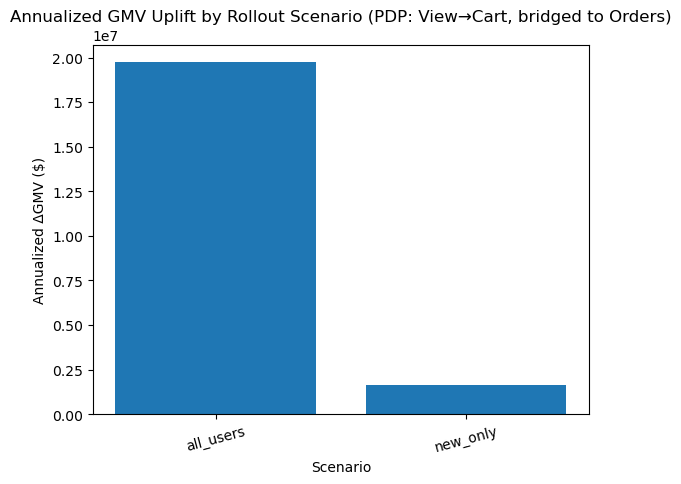

In [7]:
# 7.2 Incremental GMV（×AOV，年化）+ 图表
import matplotlib.pyplot as plt

gmv_df = orders_df.copy()
gmv_df["AOV"] = AOV
gmv_df["annualized_delta_GMV"] = gmv_df["annualized_delta_orders"] * AOV
gmv_df["annualized_GMV_CI_low"] = gmv_df["annualized_orders_CI_low"] * AOV
gmv_df["annualized_GMV_CI_high"] = gmv_df["annualized_orders_CI_high"] * AOV

display(gmv_df[[
    "scenario","N_users_in_window","delta_orders_in_window","annualized_delta_orders",
    "annualized_delta_GMV","annualized_GMV_CI_low","annualized_GMV_CI_high",
    "bridge_p_purchase_given_cart"
]])

plt.figure()
plt.bar(gmv_df["scenario"], gmv_df["annualized_delta_GMV"])
plt.title("Annualized GMV Uplift by Rollout Scenario (PDP: View→Cart, bridged to Orders)")
plt.xlabel("Scenario")
plt.ylabel("Annualized ΔGMV ($)")
plt.xticks(rotation=15)
plt.show()


In [8]:
# 7.3 Cost Sensitivity（best/base/worst）+ ROI 表

cost_cases = pd.DataFrame([
    {"cost_case": "best", "annual_cost": COST_BEST},
    {"cost_case": "base", "annual_cost": COST_BASE},
    {"cost_case": "worst", "annual_cost": COST_WORST},
])

roi_rows = []
for _, row in gmv_df.iterrows():
    for _, c in cost_cases.iterrows():
        roi_rows.append({
            "scenario": row["scenario"],
            "cost_case": c["cost_case"],
            "annualized_delta_GMV": row["annualized_delta_GMV"],
            "annual_cost": c["annual_cost"],
            "annual_ROI": row["annualized_delta_GMV"] - c["annual_cost"]
        })

roi_df = pd.DataFrame(roi_rows).sort_values(["scenario","cost_case"])
roi_df



,scenario,cost_case,annualized_delta_GMV,annual_cost,annual_ROI
1,all_users,base,1.973450e+07,80000,1.965450e+07
0,all_users,best,1.973450e+07,20000,1.971450e+07
2,all_users,worst,1.973450e+07,200000,1.953450e+07
4,new_only,base,1.631257e+06,80000,1.551257e+06
3,new_only,best,1.631257e+06,20000,1.611257e+06
5,new_only,worst,1.631257e+06,200000,1.431257e+06


In [9]:
# 7.4 Rollout Plan（10% → 50% → 100%）

rollout_doc = f"""
## Phase 7 — ROI & Rollout Decision (PDP UI: View→Cart)

### ROI Summary
- Data window: {WINDOW_DAYS} days (annualize factor = {ANNUALIZE_FACTOR:.2f})
- AOV assumption: ${AOV:.2f}
- Uplift source: ITT Δ(Add-to-Cart) from exposure-aware offline A/B (PDP)
- Conversion bridge: p(purchase | cart) estimated from control users = {bridge:.4f}

### Recommended Rollout
**Stage 1 — 10% (Canary)**
- Goal: stability + direction check
- Guardrails: error rate / latency / funnel health must not worsen

**Stage 2 — 50% (Scale Validation)**
- Goal: validate effect persistence at larger scale
- Monitor: Add-to-Cart, downstream Purchase, SRM, segment splits

**Stage 3 — 100% (Full Rollout)**
- Goal: full deployment
- Continue monitoring weekly: Add-to-Cart / Purchase / GMV / segment heterogeneity

### Stop Conditions (Rollback)
- Guardrail regression (latency/error spikes)
- SRM anomaly after rollout
- Add-to-Cart turns negative beyond noise for 2 consecutive checks
"""
print(rollout_doc)



## Phase 7 — ROI & Rollout Decision (PDP UI: View→Cart)

### ROI Summary
- Data window: 30 days (annualize factor = 12.17)
- AOV assumption: $80.00
- Uplift source: ITT Δ(Add-to-Cart) from exposure-aware offline A/B (PDP)
- Conversion bridge: p(purchase | cart) estimated from control users = 0.5111

### Recommended Rollout
**Stage 1 — 10% (Canary)**
- Goal: stability + direction check
- Guardrails: error rate / latency / funnel health must not worsen

**Stage 2 — 50% (Scale Validation)**
- Goal: validate effect persistence at larger scale
- Monitor: Add-to-Cart, downstream Purchase, SRM, segment splits

**Stage 3 — 100% (Full Rollout)**
- Goal: full deployment
- Continue monitoring weekly: Add-to-Cart / Purchase / GMV / segment heterogeneity

### Stop Conditions (Rollback)
- Guardrail regression (latency/error spikes)
- SRM anomaly after rollout
- Add-to-Cart turns negative beyond noise for 2 consecutive checks

